In [1]:
from src.generate_surfaces import ResponseFunction, six_curve_sum
import torch
from ax import Client, RangeParameterConfig
from src import BO_visuals
from torch._tensor import Tensor
import importlib

from src.BO_visuals.GPVisualiser import GPVisualiserMatplotlib, get_obs_from_client
from botorch.models import SingleTaskGP

Using font family: Brisbane Trial


# Single prediction

## initialise response and client

In [2]:
simple_func = lambda x: sum(x)
resp = ResponseFunction(simple_func, 3)
# 1. Initialize the Client.
client = Client()


## configure the search domain

In [3]:
# 2. Configure where Ax will search.
client.configure_experiment(
    name="booth_function",
    parameters=[
        RangeParameterConfig(
            name=f"x{i}",
            bounds=(0, 20.0),
            parameter_type="float",
        ) for i in range(3)
    ],
)

In [4]:

client.configure_optimization(objective="booth")

In [5]:
for _ in range(60):

    for trial_index, parameters in client.get_next_trials(max_trials=1).items():
        coordinates = torch.tensor(
            [[parameters[f"x{i}"]] for i in range(3)], dtype=torch.float64
        )

        client.complete_trial(
            trial_index=trial_index,
            raw_data={
            "booth": resp.evaluate(coordinates)[0].item()
            },
        )

client.get_best_parameterization()

[INFO 09-16 13:25:47] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-16 13:25:47] ax.api.client: Generated new trial 0 with parameters {'x0': 10.0, 'x1': 10.0, 'x2': 10.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-16 13:25:47] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-16 13:25:47] ax.api.client: Generated new trial 1 with parameters {'x0': 14.959172, 'x1': 14.438565, 'x2': 8.768587} using GenerationNode Sobol.
[INFO 09-16 13:25:47] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-16 13:25:47] ax.api.client:

({'x0': 20.0, 'x1': 20.0, 'x2': 20.0}, {'booth': (60.0, nan)}, 6, '6_0')

Check structured result.

In [6]:
print("Results DataFrame:")
results = get_obs_from_client(client)
results

Results DataFrame:


,x0,x1,x2,response
0,10.000000,10.000000,10.000000,30.000000
1,14.959172,14.438565,8.768587,38.166323
2,8.065440,6.584706,14.546922,29.197067
3,2.166366,15.302458,2.920732,20.389557
4,15.311389,3.693716,18.705171,37.710277
5,20.000000,17.491521,11.031782,48.523302
6,20.000000,20.000000,20.000000,60.000000
7,16.471576,20.000000,20.000000,56.471576
8,20.000000,18.161303,20.000000,58.161303
9,20.000000,17.845558,20.000000,57.845558


Visualise best guess dimensions

c:\GitHub\BO-Coli\src\BO_visuals\GPVisualiser.py:129: InputDataWarning:

The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\botorch\models\utils\assorted.py:270: InputDataWarning:

Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.



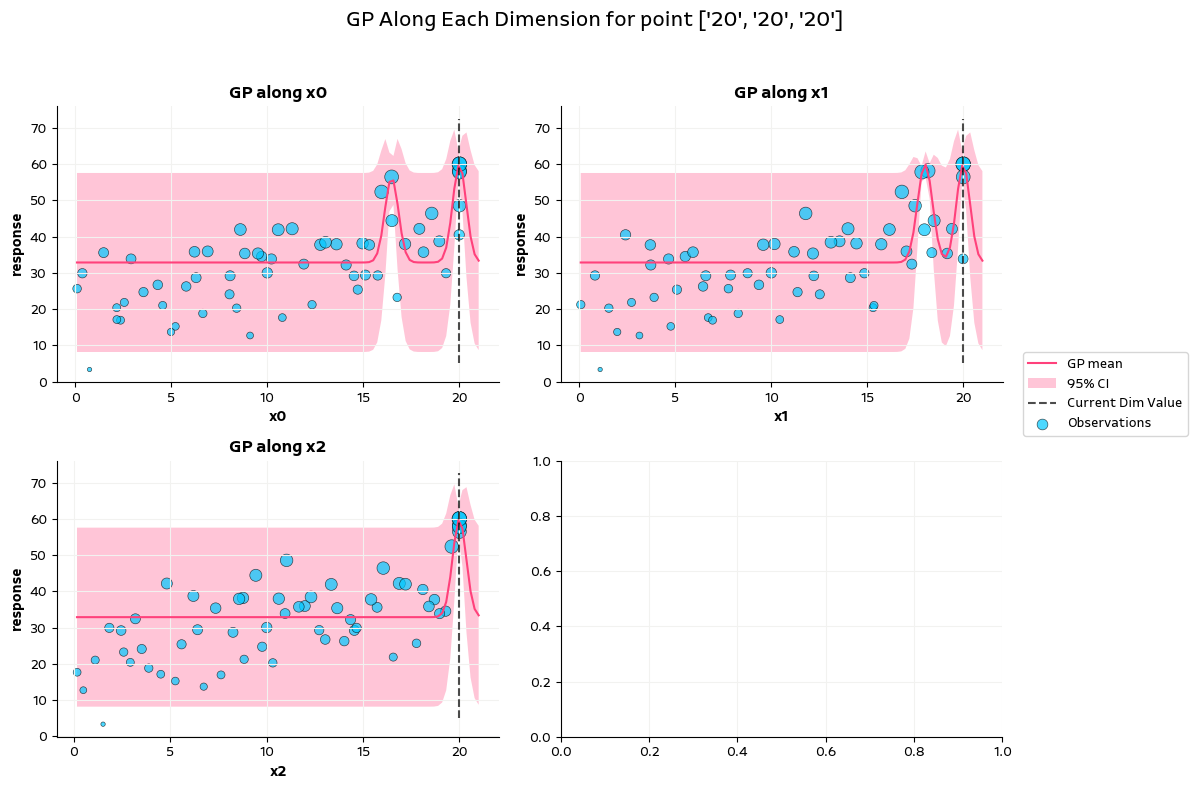

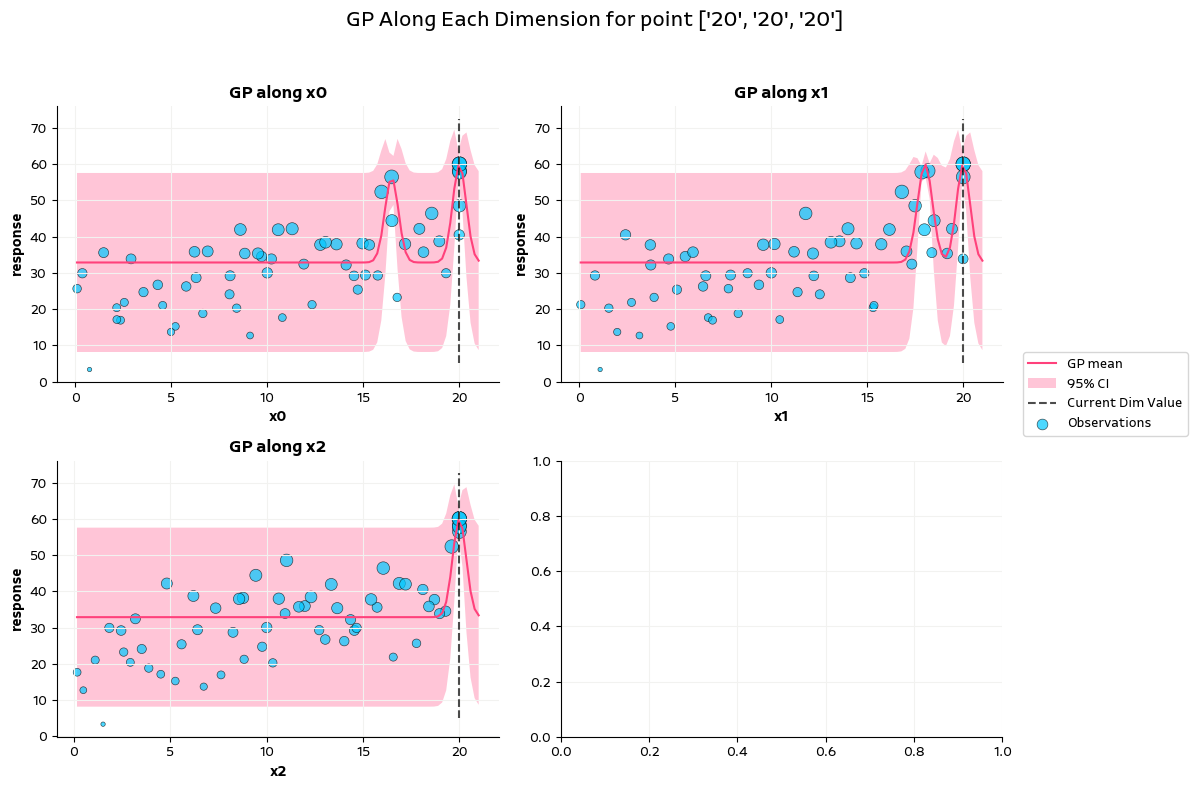

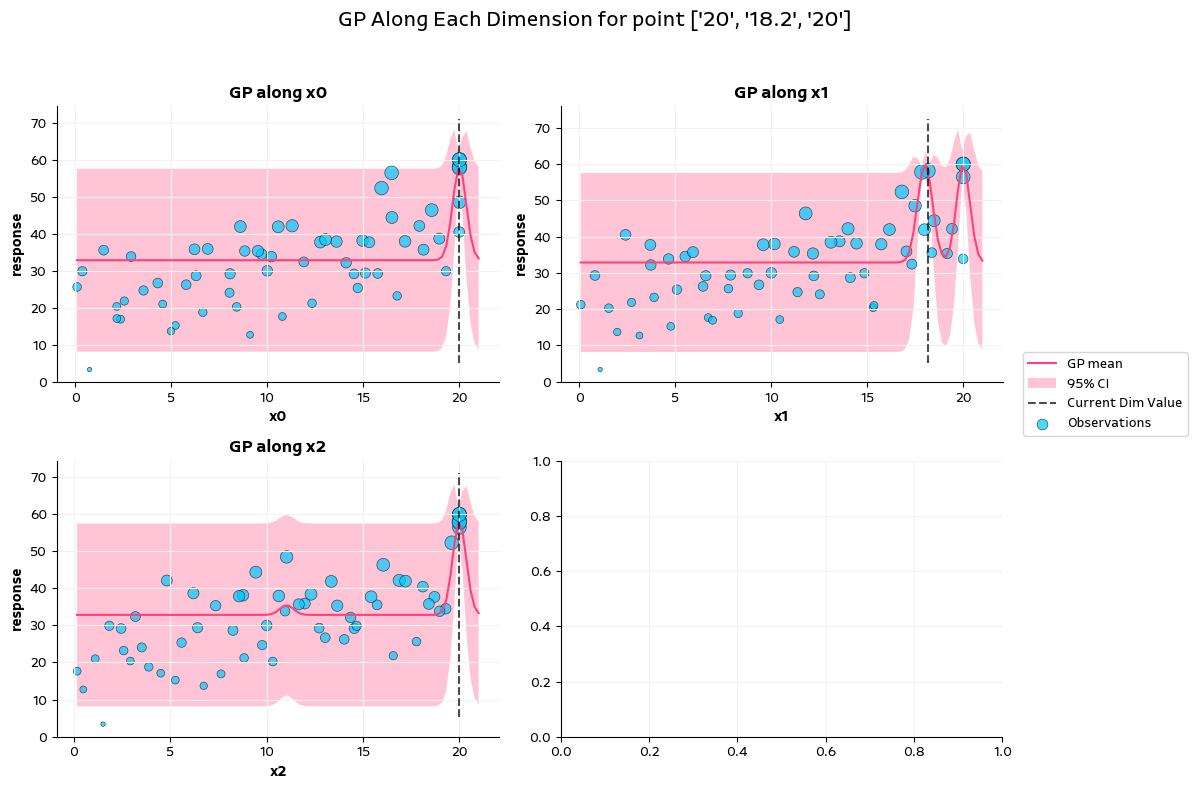

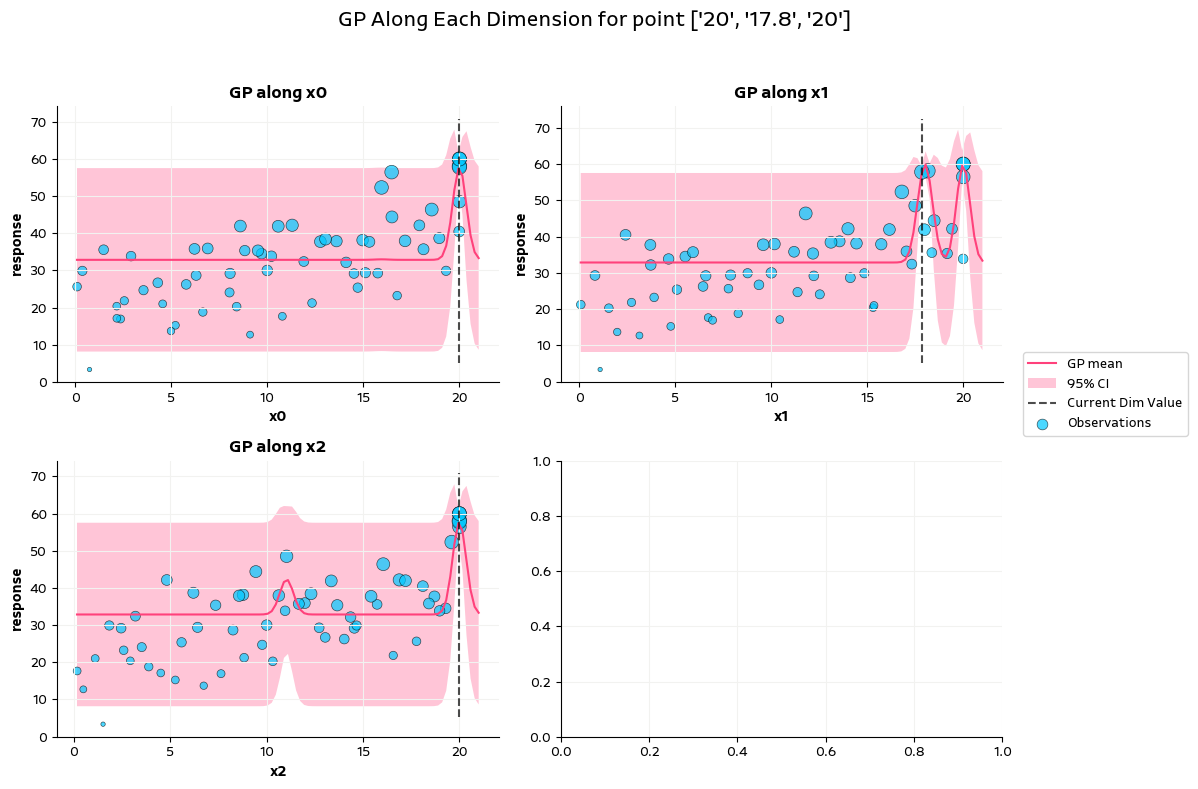

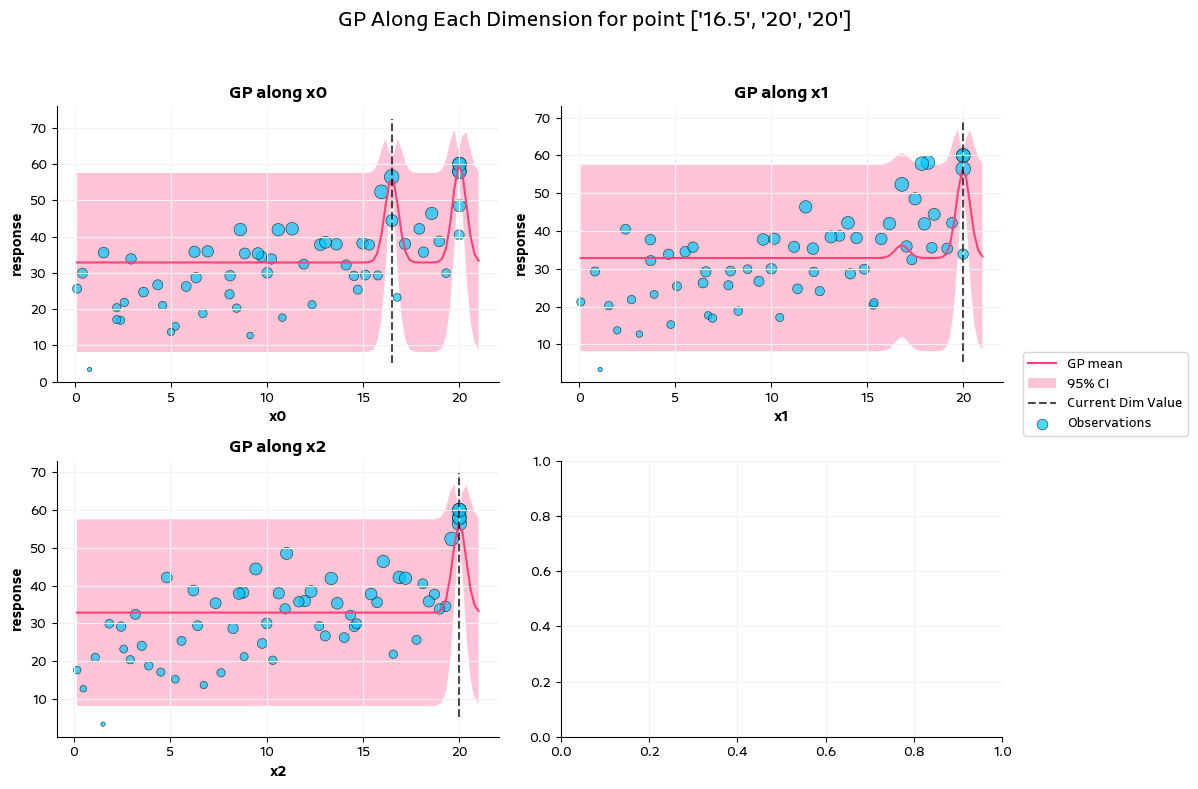

In [10]:
plotter = GPVisualiserMatplotlib(SingleTaskGP, results)


for i in range(5):

    plotter.plot_all(results.sort_values(by="response", ascending=False).iloc[i,:])
